# Quantify transports through the Faroe-Shetland Channel by source and destination

- Lagrangian particle tracking in VIKING20X model

- Pilot test case for June 2016

- Particles tracked backwards for 2 years (for sources) and forward for 6 months (for destinations)

- Advection only

- Transport calculations based on the idea of particle track representing a streamtube with constant along-tube transport everywhere

The idea here is to use Lagrangian particle tracks to quantify model volume transports from the North Atlantic into the Arctic seas by source. This is partly motivated by an idea of Stuart's that 'all' the water heading north between Greenland-Iceland-Shetland goes through the Rockall Trough (with the northward transport west of the Rockall Bank circulating in the subpolar gyre).

I've started with the Iceland-Faroes Ridge (IFR) section then moved on to Faroe-Shetland Channel and Greenland-Iceland. See other notebooks.

Obviously it is easier to quantify transports across sections from the model just by straight eulerian calculation, but even if this is done over the whole boundary of a closed volume it doesn't give you the pathways through the volume. A 3D streamfunction would be another possibility but that doesn't seem straightforward.

The basic idea is that each particle tracked represents a streamtube (I have no diffusion in the tracking). The volume transport along that streamtube is constant at any point along the length and determined by the transport where it crosses IFR. This we get by a simple calculation of cross-sectional area x velocity across the section.

Particles are positioned randomly in 2D along a section from Iceland to Faroes, then the same particles are tracked backwards for 2 years for sources and forwards for 6 months for destinations.

This is done using OceanParcels tracking software and Viking20x model fields on GEOMAR servers via python Jupyter notebooks. This notebook has the analysis of the tracks, the notebook running Parcels is separate. This is currently just testing the method, how many particles might be needed for robust results, most efficient initial particle distributions, etc.

The transport quantities are at the very end. 2000 particles across the section seems to give OK results but ideally might want more - s.d. in total transport across IFR of maybe 10-20% by selecting a different random 2000 particles. Also this is just a snapshot (though using monthly means). With a few (<10) different crossing times I've seen total transports between 2 and 7 Sv, so with 2000 particles sampling errors probably small compared to variability.


So, here we
- load lagrangian trajectory data that has been written by OceanParcels from particle tracking in Viking20x model (currently using monthly mean fields for speed)
    - particles tracked from a section across IFR
    - random release points along section
    - tracked forward for 6 months to id destinations
    - tracked backwards for 2 years to id sources
- plot sections
- plot trajectories
- subset trajectories based on source and destination
- estimate transports

Transports associated with different pathways are estimated by assuming that each particle crossing IFR has an associated volume transport, which it maintains throughout its life, given by the 
                velocity across the section * total cross-sectional area / number of particles
So like a streamtube...    

## To do

- calculate section area properly 
- explore sensitivity to particle numbers and random seed (i.e. do I have enough particles)
- calculate true transport across section in model
- not selecting ocean particles properly near bed - partial cells
- fix time units on track plots

## Technical preamble

In [1]:
%matplotlib inline

import matplotlib.colors as colors
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib.colors import ListedColormap
import cmocean as co

sns.set_palette("Paired")

## Parameters

In [2]:
# release time

trelease = np.datetime64('2015-12-16T12:00')

# Project path
project_path = Path.cwd() / '..' / '..' 
project_path = project_path.resolve()

# project_path = Path("C:/Users/sa05af/OneDrive - SAMS/Projects/parcels_quantitative_202004/")

# Parcels track data file
path_data_tracks = Path('data/processed/tracks/FaroeShetland/') 
filename = 'tracks_parcels_FS_forwards_201512.nc'
filenameb = 'tracks_parcels_FS_backwards_201512.nc'

# model mask file
data_path = Path("data/external/iAtlantic/")
experiment_name = "VIKING20X.L46-KKG36107B"
mesh_mask_file = project_path / data_path / "mask" / experiment_name / "1_mesh_mask.nc"

#velocity conversions on IFR (61N)

lat2metres = 60.0*1852.0
lon2metres = 60.0*1852.0*np.cos(np.radians(61.0))

sealandratio = 5591.0/20000.0
sectionAreaEW = 5.7 * 1500.0 * sealandratio * lon2metres  # very approx. mean depth x length between slopes.
sectionAreaNS = 1.87 * 1500.0 * sealandratio * lat2metres

nParticles = 2000.0

## Some helper and plotting functions

In [3]:
def plot_release():
    plt.figure(figsize = (12,5))

    plt.scatter(
        ds.isel(obs=0).lon.data.flatten(),
        ds.isel(obs=0).z.data.flatten(),
        20,
        ds.isel(obs=0).vvel.data.flatten()*lon2metres
         , vmin = -.2, vmax = .2
        ,cmap= co.cm.balance
    #    ,alpha=0.3
    )

    plt.ylim(1500,0)

    plt.colorbar(label = "vvel [m/s]")
    plt.show()
    return


In [4]:
def plot_tracks(x,y,z,title):
    plt.figure(figsize = (15,9))

    # plot tracks as scatter plots

    plt.scatter(
        x
        ,y
        ,3
        ,z
        ,vmin = tvmin, vmax = tvmax
        ,cmap = co.cm.delta
    #    ,alpha=0.3
    )
    plt.colorbar(label = "time [stupid units. range 4 years, all cross IFR at 2 years]");

    # plot depth contours and land boundary from model bathymetry
    depth.isel(y=slice(1700, 2499), x=slice(1300, 2404)).plot.contour(
        x="nav_lon", y="nav_lat", colors = 'grey', levels = [200,800,1500,2000,2500,3500]
    );
    depth.isel(y=slice(1700, 2499), x=slice(1300, 2404)).plot.contour(
        x="nav_lon", y="nav_lat", colors = 'k', levels = [1]
    );
    # plt.savefig('upstream.png')
    plt.ylim(45,70)
    plt.xlim(-50,10)
    plt.title(title)
    plt.show()
    return

In [5]:
def plot_section():
    plt.figure(figsize = (12,7))

    plt.scatter(
        ds.isel(obs=0).lon.data.flatten(),
        ds.isel(obs=0).z.data.flatten(),
        s = 20, color = 'k', label='from other, went other'
    )
    plt.scatter(
        ds.where(ds_area.isel(obs=-1).F_NFaroes).isel(obs=0).lon.data.flatten(),
        ds.where(ds_area.isel(obs=-1).F_NFaroes).isel(obs=0).z.data.flatten(),
        s = 20, label='round N Faroe, went other'
    )
    plt.scatter(
        ds.where(ds_area.isel(obs=-1).F_NFaroes).isel(obs=0).where(ds_area.isel(obs=-1).T_NorwSea).lon.data.flatten(),
        ds.where(ds_area.isel(obs=-1).F_NFaroes).isel(obs=0).where(ds_area.isel(obs=-1).T_NorwSea).z.data.flatten(),
        s = 20, label='round N Faroe, went Norwegian Sea'
    )
    plt.scatter(
        ds.where(ds_area.isel(obs=-1).F_NFaroes).where(ds_area.isel(obs=-1).F_WIceland).isel(obs=0).lon.data.flatten(),
        ds.where(ds_area.isel(obs=-1).F_NFaroes).where(ds_area.isel(obs=-1).F_WIceland).isel(obs=0).z.data.flatten(),
        s = 20, label='from W Iceland, round N Faroe, went other'
    )
    plt.scatter(
        ds.where(ds_area.isel(obs=-1).F_NFaroes).where(ds_area.isel(obs=-1).F_WIceland).where(ds_area.isel(obs=-1).T_NorwSea).isel(obs=0).lon.data.flatten(),
        ds.where(ds_area.isel(obs=-1).F_NFaroes).where(ds_area.isel(obs=-1).F_WIceland).where(ds_area.isel(obs=-1).T_NorwSea).isel(obs=0).z.data.flatten(),
        s = 20, label='from W Iceland, round N Faroe, went Norwegian Sea'
    )
    plt.scatter(
        ds.where(ds_area.isel(obs=-1).F_NFaroes).where(ds_area.isel(obs=-1).F_GreenSea).isel(obs=0).lon.data.flatten(),
        ds.where(ds_area.isel(obs=-1).F_NFaroes).where(ds_area.isel(obs=-1).F_GreenSea).isel(obs=0).z.data.flatten(),
        s = 20, label='from Greenland Sea, round N Faroe, went other'
    )
    plt.scatter(
        ds.where(ds_area.isel(obs=-1).F_NFaroes).where(ds_area.isel(obs=-1).F_GreenSea).where(ds_area.isel(obs=-1).T_NorwSea).isel(obs=0).lon.data.flatten(),
        ds.where(ds_area.isel(obs=-1).F_NFaroes).where(ds_area.isel(obs=-1).F_GreenSea).where(ds_area.isel(obs=-1).T_NorwSea).isel(obs=0).z.data.flatten(),
        s = 20, label='from Greenland Sea, round N Faroe, went Norwegian Sea'
    )
    plt.scatter(
        ds.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_WRB).isel(obs=0).lon.data.flatten(),
        ds.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_WRB).isel(obs=0).z.data.flatten(),
        s = 20, color = 'lightgrey', label='from WRB, went other'
    )
    plt.scatter(
        ds.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_WRB).where(ds_area.isel(obs=-1).T_NorwSea).isel(obs=0).lon.data.flatten(),
        ds.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_WRB).where(ds_area.isel(obs=-1).T_NorwSea).isel(obs=0).z.data.flatten(),
        s = 20, label='from WRB, went Norwegian Sea'
    )
    plt.scatter(
        ds.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_WRB).where(ds_area.isel(obs=-1).T_NSea).isel(obs=0).lon.data.flatten(),
        ds.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_WRB).where(ds_area.isel(obs=-1).T_NSea).isel(obs=0).z.data.flatten(),
        s = 20, label='from WRB, through North Sea'
    )
    plt.scatter(
        ds.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_RT_WSS).isel(obs=0).lon.data.flatten(),
        ds.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_RT_WSS).isel(obs=0).z.data.flatten(),
        s = 20, color = 'grey', label='from RT, went other'
    )
    plt.scatter(
        ds.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_RT_WSS).where(ds_area.isel(obs=-1).T_NorwSea).isel(obs=0).lon.data.flatten(),
        ds.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_RT_WSS).where(ds_area.isel(obs=-1).T_NorwSea).isel(obs=0).z.data.flatten(),
        s = 20, label='from RT, went Norwegian Sea'
    )
    plt.scatter(
        ds.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_RT_WSS).where(ds_area.isel(obs=-1).T_NSea).isel(obs=0).lon.data.flatten(),
        ds.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_RT_WSS).where(ds_area.isel(obs=-1).T_NSea).isel(obs=0).z.data.flatten(),
        s = 20, label='from RT, through North Sea'
    )
    plt.legend(ncol=2)

    plt.ylim(2000,0)
    
    return

In [6]:
def apply_through_area(ds, min_lon, max_lon, min_lat, max_lat, min_time, max_time, criterion_name):
    '''Apply an area crossing criterion.
    
    Larvae in ds selected if they pass through given area.
    '''
    # particles are selected if they pass through given area.
    particle_out =  (
                    (ds.lon > min_lon) * 
                    (ds.lon < max_lon) *
                    (ds.lat > min_lat) * 
                    (ds.lat < max_lat) *
                    (ds.time > min_time) *
                    (ds.time < max_time)
                    )
                    
#     particle_out = (ds.temp < max_lat)
    

    # last place in array determines if particle went through area  
    is_thru = (particle_out.cumsum("obs") != 0)
    
#     print(particle_out.max())
    
    # add data to original ds
    ds[criterion_name] = is_thru
    
    return ds

In [7]:
def apply_left_of_line(ds, lon_1, lon_2, lat_1, lat_2, min_time, max_time, criterion_name):
    '''Apply an area crossing criterion.
    
    Larvae in ds selected if they pass through given area.
    '''
    # particles are selected if they pass through given area.
    particle_out =  ((((lon_2 -lon_1) * (ds.lat - lat_1) - 
                     (ds.lon - lon_1) * (lat_2 - lat_1))
                     > 0.0) *
                    (ds.time > min_time) *
                    (ds.time < max_time))
                    
#     particle_out = (ds.temp < max_lat)
    

    # last place in array determines if particle went through area  
    is_thru = (particle_out.cumsum("obs") != 0)
    
#     print(particle_out.max())
    
    # add data to original ds
    ds[criterion_name] = is_thru
    
    return ds

In [8]:
def mask_tracks_by_source_sink(ds_full,trelease):
    # comes through Rockall Trough and W Scotland shelf
    ds_area = apply_through_area(ds_full,-13.5,-6.5,57.25,57.75,
                                 np.datetime64('2010-06-15'),trelease,
                                 'F_RT_WSS')    
    # comes northward west of Rockall Bank
    ds_area = apply_through_area(ds_area,-60,-13.5,57.25,57.75,
                                 np.datetime64('2010-06-15'),trelease,
                                 'F_WRB')  
    # comes clockwise round Iceland
    ds_area = apply_through_area(ds_area,-22,-20,65,70,
                                 np.datetime64('2010-06-15'),trelease,
                                 'F_WIceland')  
    # comes from NW
    ds_area = apply_through_area(ds_area,-20,-6,68.5,70,
                                 np.datetime64('2010-06-15'),trelease,
                                 'F_GreenSea')  
    # goes northeastward towards Arctic - all particles doing this pass north of Faroe
    ds_area = apply_through_area(ds_area,-6.5,-5.5,62.3,64.5,
                                 np.datetime64('2010-06-15'),trelease,
                                 'F_NFaroes')    
    # goes west south of Iceland in SPG
    ds_area = apply_through_area(ds_area,-23,-22,62.,64.,
                                 trelease,np.datetime64('2020-06-15'),
                                 'T_SIceland')  
    # goes to arctic
    ds_area = apply_left_of_line(ds_area,0,7,65,62,
                                 trelease,np.datetime64('2020-06-15'),
                                 'T_NorwSea')
    # goes to north sea
    ds_area = apply_left_of_line(ds_area,5.1,-1.23,62.3,60.3,
                                 trelease,np.datetime64('2020-06-15'),
                                 'T_NSea')
    return ds_area

In [9]:
def transports():
    NEwardsParticleTransport = (sectionAreaEW*dsb.isel(obs=0).vvel*lat2metres +
                            sectionAreaNS*dsb.isel(obs=0).uvel*lon2metres)/nParticles
    print('Total transport northwards through F-S channel..........',
          '{: .3f}'.format(NEwardsParticleTransport.sum().data/1.0e06),'  Sv')
    print('...of which, from round N of Faroe......................',
          '{: .3f}'.format(NEwardsParticleTransport.where(ds_area.isel(obs=-1).F_NFaroes).sum().data/1.0e06),'  Sv')
    print('...remainder excluding from round N of Faroe............',
          '{: .3f}'.format(NEwardsParticleTransport.where(ds_area.isel(obs=-1).F_NFaroes == False).sum().data/1.0e06),'  Sv')
    print('......of which, to Norwegian Sea........................',
          '{: .3f}'.format(NEwardsParticleTransport.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).T_NorwSea).sum().data/1.0e06),'  Sv')
    print('.............of which, from Rockall Trough..............',
          '{: .3f}'.format(NEwardsParticleTransport.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).T_NorwSea).where(ds_area.isel(obs=-1).F_RT_WSS).sum().data/1.0e06),'  Sv')
    print('....................., and from West of Rockall.........',
          '{: .3f}'.format(NEwardsParticleTransport.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).T_NorwSea).where(ds_area.isel(obs=-1).F_RT_WSS == False).where(ds_area.isel(obs=-1).F_WRB).sum().data/1.0e06),'  Sv')
    return

## Load data

### Forward tracks then backward tracks

In [10]:
ds = xr.open_dataset(project_path / path_data_tracks / filename)
dsb = xr.open_dataset(project_path / path_data_tracks / filenameb)
ds_full = xr.concat([dsb,ds],dim='obs')

display(ds_full)

<xarray.Dataset>
Dimensions:     (obs: 1462, traj: 2000)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) float64 3.0 3.0 3.0 3.0 3.0 ... nan nan nan nan nan
    time        (traj, obs) datetime64[ns] 2015-12-16T12:00:00 ... NaT
    lat         (traj, obs) float64 61.17 61.18 61.19 61.21 ... nan nan nan nan
    lon         (traj, obs) float64 -3.858 -3.807 -3.755 -3.718 ... nan nan nan
    z           (traj, obs) float64 551.4 555.8 560.1 563.9 ... nan nan nan nan
    temp        (traj, obs) float32 1.742226 1.7405465 1.7274325 ... nan nan nan
    uvel        (traj, obs) float32 -7.0260165e-07 -5.840501e-07 ... nan nan
    vvel        (traj, obs) float32 -7.4971354e-08 -1.2900848e-07 ... nan nan
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.1.2
    parcels_mesh:           spherical

### Load model mesh mask

In [11]:
mesh_mask = xr.open_dataset(mesh_mask_file)
mesh_mask = mesh_mask.squeeze()
mesh_mask = mesh_mask.set_coords(["nav_lon", "nav_lat", "nav_lev"])

bathy = mesh_mask.mbathy.rename("number of water filled points")

depth = (mesh_mask.e3t_0 * mesh_mask.tmask).sum("z")
# display(mesh_mask)

## Have a quick look

### Release positions of the particles on section from Faroes to Shetland

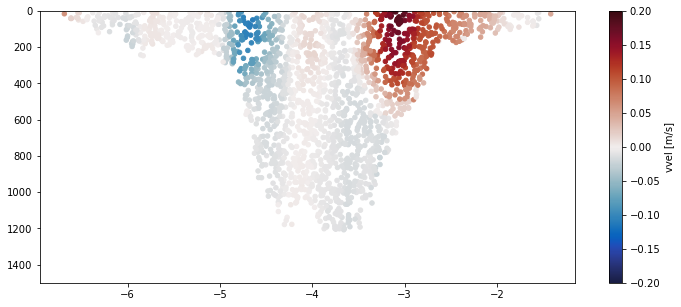

In [12]:
plot_release()

## Calculate some basic parameters from data for later

In [13]:
nParticles = ds.sizes['traj']

In [14]:
#centre time colourscale on release *DOESN'T WORK ON WINDOWS*
tvmin = dsb.time.min(skipna=True).data # oldest time
tvcentre = dsb.time.max(skipna=True).data # oldest time

tvmax = tvcentre + (tvcentre - tvmin)

print(tvmin,tvcentre,tvmax)

2013-12-16T12:00:00.000000000 2015-12-16T12:00:00.000000000 2017-12-15T12:00:00.000000000


### Plot trajectories

In [15]:
lon =    ds_full.where(ds_full.time > np.datetime64('2010-06-15')).lon.data.flatten()
lat =    ds_full.where(ds_full.time > np.datetime64('2010-06-15')).lat.data.flatten()
time =   ds_full.where(ds_full.time > np.datetime64('2010-06-15')).time.data.flatten()
 

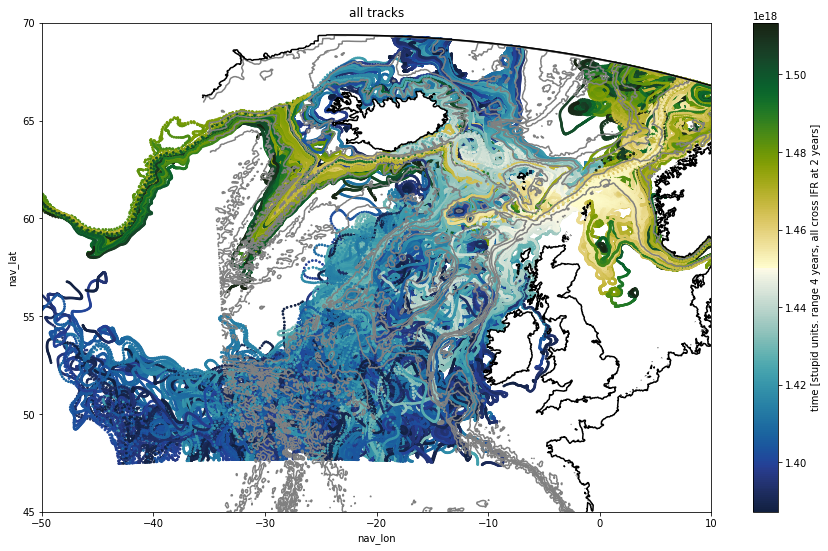

In [16]:
plot_tracks(lon,lat,time,'all tracks')

### Find subsets of trajectories passing through different areas, either upstream or downstream

This just tests whether particles were ever in an area, much easier than testing line crossings.

In [17]:
ds_area = mask_tracks_by_source_sink(ds_full,trelease)

## Plot tracks for some cases

### Tracks reaching FSC round north of Faroe. 

Many of these crossed between Iceland and Faroe.

In [18]:
lon =   ds_area.where(ds_area.isel(obs=-1).F_NFaroes).lon.data.flatten()
lat =   ds_area.where(ds_area.isel(obs=-1).F_NFaroes).lat.data.flatten()
time =  ds_area.where(ds_area.isel(obs=-1).F_NFaroes).time.data.flatten()

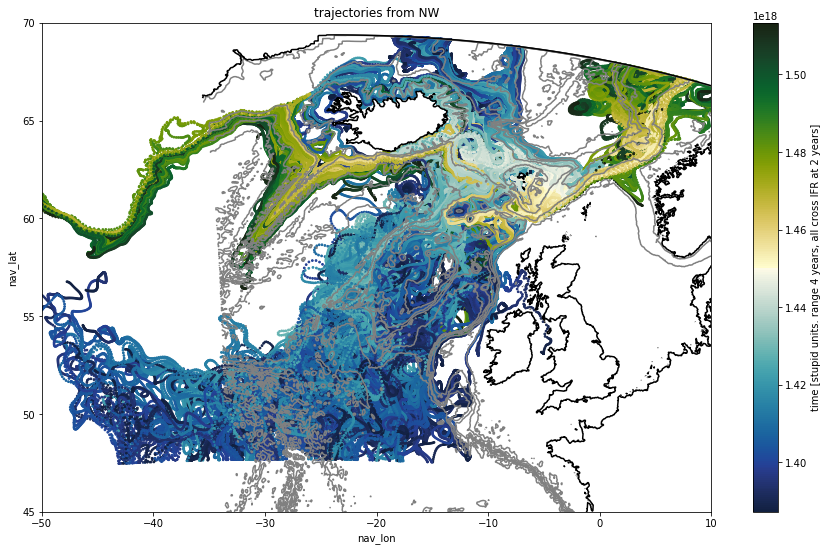

In [19]:
plot_tracks(lon,lat,time,'trajectories from NW')

### Tracks reaching FSC from south

In [20]:
lon =    ds_area.where(ds_area.isel(obs=-1).F_NFaroes == False).lon.data.flatten()
lat =    ds_area.where(ds_area.isel(obs=-1).F_NFaroes == False).lat.data.flatten()
time =  ds_area.where(ds_area.isel(obs=-1).F_NFaroes == False).time.data.flatten()

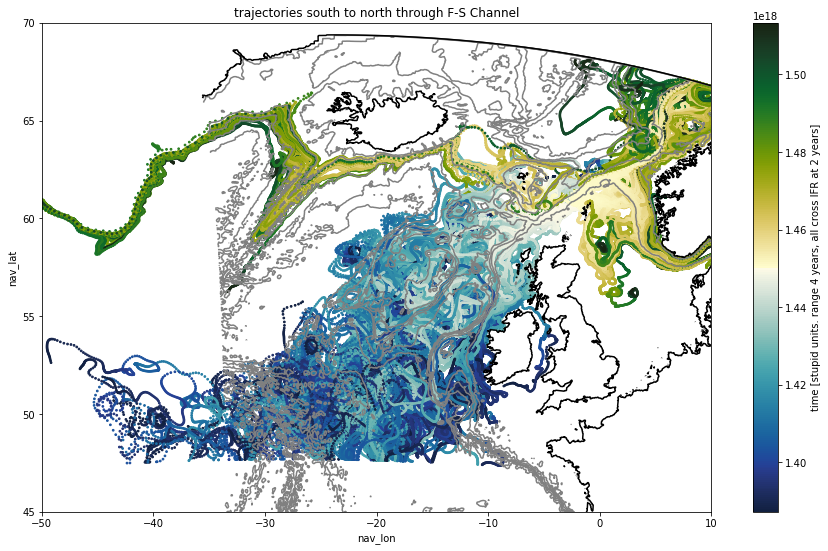

In [21]:
plot_tracks(lon,lat,time,'trajectories south to north through F-S Channel')

### Tracks reaching FSC from south through Rockall Trough

In [22]:
lon =    ds_area.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_RT_WSS).lon.data.flatten()
lat =    ds_area.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_RT_WSS).lat.data.flatten()
time =    ds_area.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_RT_WSS).time.data.flatten()

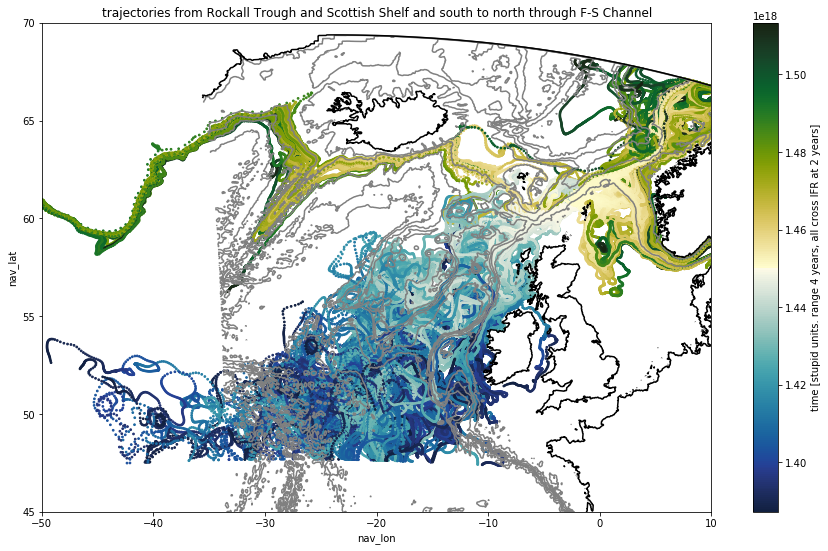

In [23]:
plot_tracks(lon,lat,time,'trajectories from Rockall Trough and Scottish Shelf and south to north through F-S Channel')

#### From Rockall Trough excluding particles and heading northwards

In [24]:
lon =    (ds_area.where(ds_area.isel(obs=-1).F_NFaroes == False)
                .where(ds_area.isel(obs=-1).F_RT_WSS)
                .where(ds_area.isel(obs=-1).T_NorwSea).lon.data.flatten())
lat =    (ds_area.where(ds_area.isel(obs=-1).F_NFaroes == False)
                .where(ds_area.isel(obs=-1).F_RT_WSS)
                .where(ds_area.isel(obs=-1).T_NorwSea).lat.data.flatten())
time =   (ds_area.where(ds_area.isel(obs=-1).F_NFaroes == False)
                .where(ds_area.isel(obs=-1).F_RT_WSS)
                .where(ds_area.isel(obs=-1).T_NorwSea).time.data.flatten())

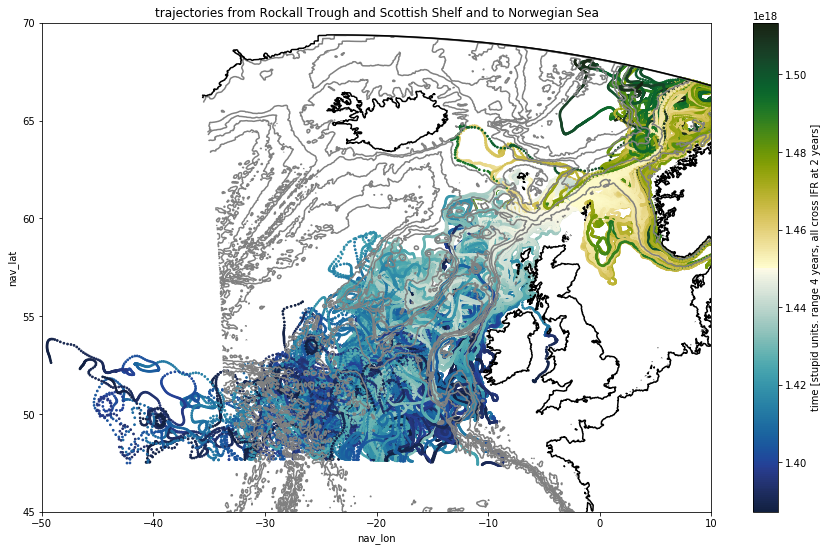

In [25]:
plot_tracks(lon,lat,time,'trajectories from Rockall Trough and Scottish Shelf and to Norwegian Sea')

One or two remain in the North Sea after 2 years

In [26]:
lon =    (ds_area.where(ds_area.isel(obs=-1).F_NFaroes == False)
                .where(ds_area.isel(obs=-1).F_RT_WSS)
                .where(ds_area.isel(obs=-1).T_NSea)
                .where(ds_area.isel(obs=-1).T_NorwSea == False).lon.data.flatten())
lat =    (ds_area.where(ds_area.isel(obs=-1).F_NFaroes == False)
                .where(ds_area.isel(obs=-1).F_RT_WSS)
                .where(ds_area.isel(obs=-1).T_NSea)
                .where(ds_area.isel(obs=-1).T_NorwSea == False).lat.data.flatten())
time =   (ds_area.where(ds_area.isel(obs=-1).F_NFaroes == False)
                .where(ds_area.isel(obs=-1).F_RT_WSS)
                .where(ds_area.isel(obs=-1).T_NSea)
                .where(ds_area.isel(obs=-1).T_NorwSea == False).time.data.flatten())

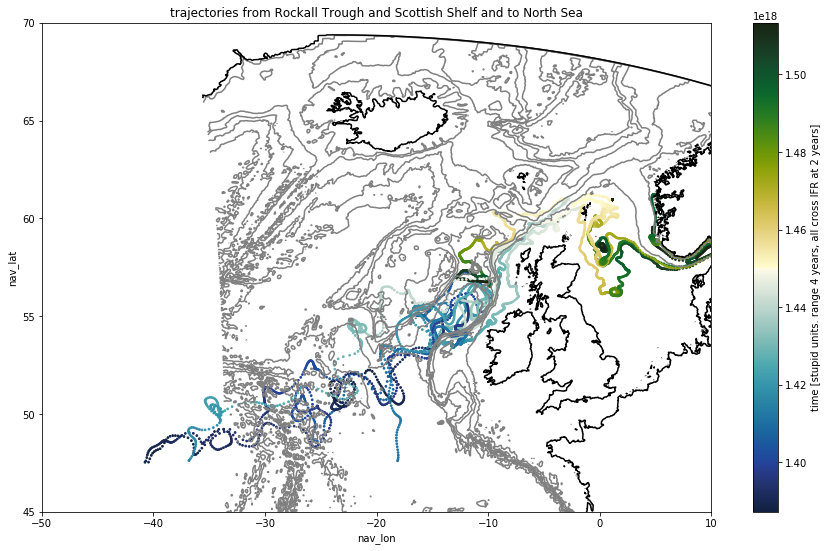

In [27]:
plot_tracks(lon,lat,time,'trajectories from Rockall Trough and Scottish Shelf and to North Sea')

### Tracks reaching FSC from south from west of Rockall

In [28]:
lon =    (ds_area.where(ds_area.isel(obs=-1).F_NFaroes == False)
                .where(ds_area.isel(obs=-1).F_RT_WSS == False)
                .where(ds_area.isel(obs=-1).F_WRB).lon.data.flatten())
lat =    (ds_area.where(ds_area.isel(obs=-1).F_NFaroes == False)
                .where(ds_area.isel(obs=-1).F_RT_WSS == False)
                .where(ds_area.isel(obs=-1).F_WRB).lat.data.flatten())
time =   (ds_area.where(ds_area.isel(obs=-1).F_NFaroes == False)
                .where(ds_area.isel(obs=-1).F_RT_WSS == False)
                .where(ds_area.isel(obs=-1).F_WRB).time.data.flatten())

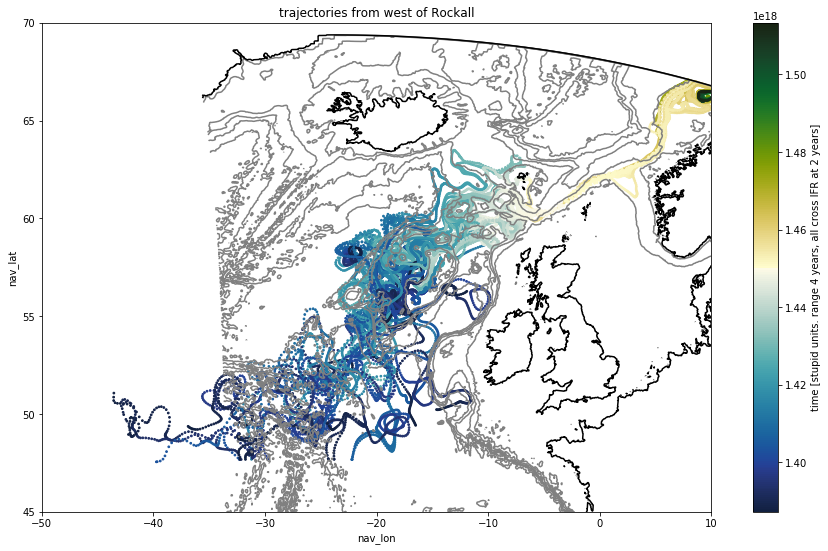

In [29]:
plot_tracks(lon,lat,time,'trajectories from west of Rockall')

A few tracks started N of the test line at 57.5&deg;N but didn't arrive from north of Faroe.

In [30]:
lon =    (ds_area.where(ds_area.isel(obs=-1).F_NFaroes == False)
                .where(ds_area.isel(obs=-1).F_RT_WSS == False)
                .where(ds_area.isel(obs=-1).F_WRB == False).lon.data.flatten())
lat =    (ds_area.where(ds_area.isel(obs=-1).F_NFaroes == False)
                .where(ds_area.isel(obs=-1).F_RT_WSS == False)
                .where(ds_area.isel(obs=-1).F_WRB == False).lat.data.flatten())
time =   (ds_area.where(ds_area.isel(obs=-1).F_NFaroes == False)
                .where(ds_area.isel(obs=-1).F_RT_WSS == False)
                .where(ds_area.isel(obs=-1).F_WRB == False).time.data.flatten())

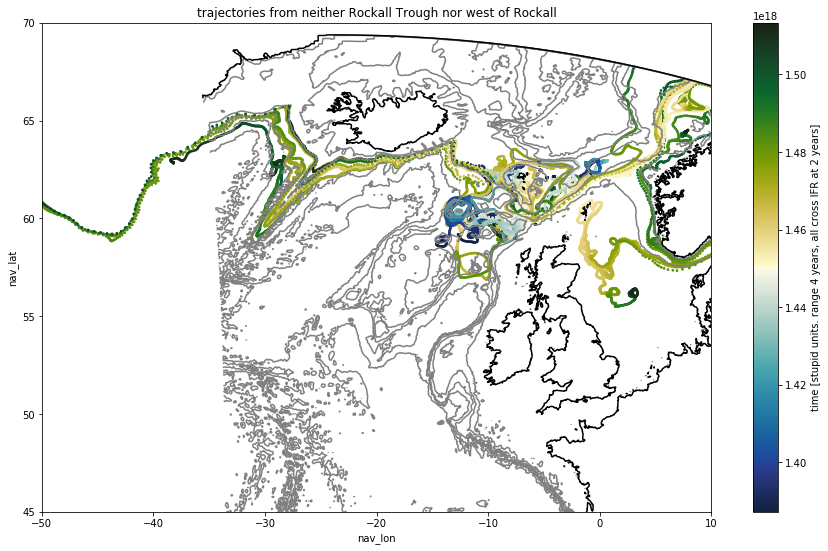

In [31]:
plot_tracks(lon,lat,time,'trajectories from neither Rockall Trough nor west of Rockall')

## Plot IFF section coloured by source

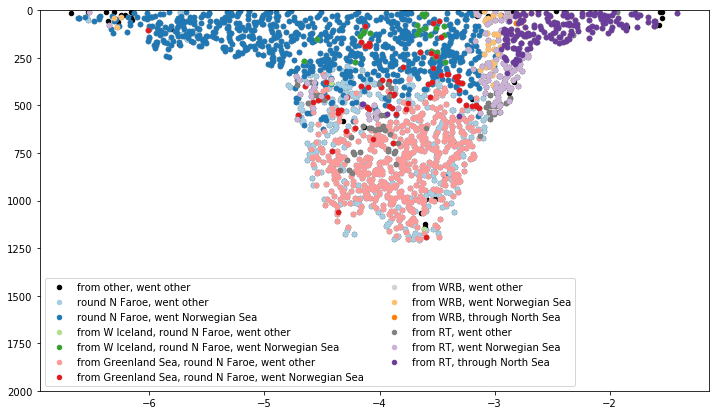

In [32]:
plot_section()

## Estimate transports through FSC

In [33]:
transports()

Total transport northwards through F-S channel..........  4.434   Sv
...of which, from round N of Faroe...................... -1.356   Sv
...remainder excluding from round N of Faroe............  5.790   Sv
......of which, to Norwegian Sea........................  5.692   Sv
.............of which, from Rockall Trough..............  4.394   Sv
....................., and from West of Rockall.........  1.037   Sv
